In [1]:
import os
import datetime
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
from sklearn.utils import class_weight
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D, ZeroPadding2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# import tensorflow_addons as tfa
#finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb

In [2]:
[x.name for x in device_lib.list_local_devices()]
# !conda install -y -n ml ipykernel=6.23.2 numpy==1.24.0 matplotlib=3.7.1 pandas=2.0.2 seaborn=0.12.1 scikit-learn=1.3.2 tensorflow=2.11.1
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb

['/device:CPU:0']

In [3]:
df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')

df_unique = df.copy()
df_unique.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
df_unique=df_unique.drop([ 'lesion_id','dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df_unique = df_unique.reset_index(drop=True)
df=df.drop([ 'lesion_id','dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)

train_df, val_df = train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx'])
train_df_unique, val_df_unique = train_test_split(df_unique, train_size=0.9, shuffle=True, random_state=123, stratify=df_unique['dx'])
df.shape, train_df.shape, val_df.shape, df_unique.shape, train_df_unique.shape, train_df_unique.shape

((10015, 2), (9013, 2), (1002, 2), (5514, 2), (4962, 2), (4962, 2))

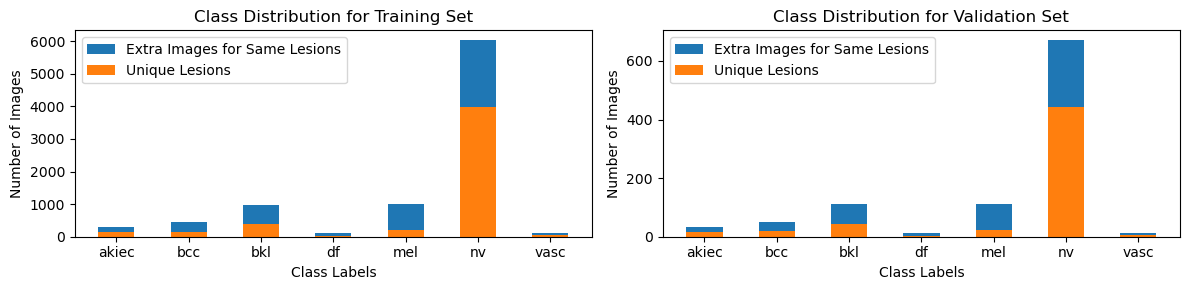

In [4]:
#plotting class distribution for lesion_id and image_id before rebalancing the class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(train_df['dx'].sort_values(),bins=bins)
ax1.hist(train_df_unique['dx'].sort_values(),bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for val set
ax2.hist(val_df['dx'].sort_values(),bins=bins)
ax2.hist(val_df_unique['dx'].sort_values(),bins=bins)
ax2.set_title("Class Distribution for Validation Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

In [5]:
def random_augment(image):
    tf.random.set_seed(123)
    # Randomly applied horizontal flip - reasonable for skin images
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness - simulate different lighting conditions
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast - simulate variations in camera quality and settings
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random rotation - lesions can be oriented in any direction
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Gaussian blur - simulate slight focus variations
    # image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=1.0)
    
    return image

In [6]:
def augmentention_on_dataset(df, df_unique, dataset_type, images_directory, max_sample, min_sample, ):
    df_unique = df_unique
    for label in df['dx'].unique():
        df_label = df[df['dx'] == label]
        df_unique_label = df_unique[df_unique['dx'] == label]
    
        #If in the label is more than n images we delete all duplicates and sometimes part of random unique imagas
        if(len(df_label) > max_sample):
            df = pd.concat([df[df['dx'] != label], df_unique[df_unique['dx'] == label]])
            df_label = df[df['dx'] == label]
            drop_indices = np.random.choice(df[df['dx'] == label].index, len(df_label) - max_sample, replace=False)
            df = pd.concat([df[df['dx'] != label], df_label.drop(drop_indices)])
        
        #If in the label is less than n images we randomly choose unique images for augmentation
        if(len(df_label) < min_sample):
            selected_indices = np.random.choice(df_unique_label.index, min_sample - len(df_label), replace=True)
            df_to_add = df_unique_label.loc[selected_indices]
            df_to_add['image_id'] = df_to_add['image_id'] + '-' + dataset_type + (df_to_add.groupby('image_id').cumcount() + 1).astype(str)
            df = pd.concat([df, df_to_add])
        
    for i in df[df['image_id'].str.len() > 12]['image_id'].values:
        image = tf.io.read_file(os.path.join(images_directory, i.split('-')[0] + '.jpg'))
        image = tf.image.decode_jpeg(image, channels=3)
    
        # Apply augmentations
        augmented_image = random_augment(image)
    
        # Convert back to image format and save the augmented image
        augmented_image = tf.cast(augmented_image, tf.uint8)
        augmented_image = tf.image.encode_jpeg(augmented_image)
        tf.io.write_file(os.path.join(images_directory, i + '.jpg'), augmented_image)
    
    df['image_id'] = df['image_id'].astype(str) + '.jpg'
    df.to_csv(f'dataverse_files/HAM10000_metadata_modified_' + dataset_type +'.csv')

In [7]:
# augmentention_on_dataset(train_df, train_df_unique, 'train_df', 
#                          os.path.join(os.getcwd(), "dataverse_files/HAM10000_images_augmented"), 1350, 720)
# augmentention_on_dataset(val_df, val_df_unique, 'val_df', 
#                          os.path.join(os.getcwd(), "dataverse_files/HAM10000_images_augmented"), 150, 80)

In [8]:
train_df_unique_augmented = pd.read_csv('dataverse_files/HAM10000_metadata_modified_train_df.csv')
val_df_unique_augmented = pd.read_csv('dataverse_files/HAM10000_metadata_modified_val_df.csv')
train_df_unique_augmented = train_df_unique_augmented.drop(['Unnamed: 0'], axis=1)
val_df_unique_augmented = val_df_unique_augmented.drop(['Unnamed: 0'], axis=1)
train_df_unique_augmented.head()

# TEST DATA
test_df = pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
test_df = test_df.drop([ 'lesion_id','dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
# if your image names have no extension
test_df['image_id'] = test_df['image_id'].astype(str) + '.jpg'
# 'ISIC_0035068.jpg' is missing in the dataset, lets remove it from test set
test_df = test_df[test_df['image_id'] != 'ISIC_0035068.jpg']
test_df.head()

,image_id,dx
0,ISIC_0034524.jpg,nv
1,ISIC_0034525.jpg,nv
2,ISIC_0034526.jpg,bkl
3,ISIC_0034527.jpg,nv
4,ISIC_0034528.jpg,nv


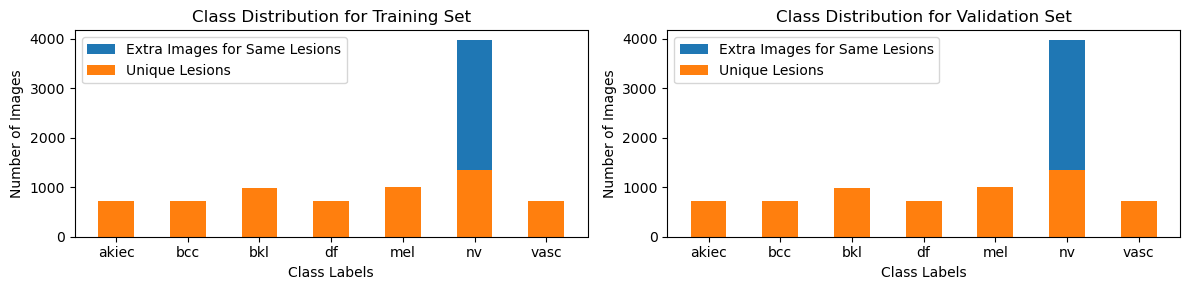

In [9]:
#plotting class distribution for lesion_id and image_id after rebalancing the class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(train_df_unique['dx'].sort_values(),bins=bins)
ax1.hist(train_df_unique_augmented['dx'].sort_values(),bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for val set
ax2.hist(train_df_unique['dx'].sort_values(),bins=bins)
ax2.hist(train_df_unique_augmented['dx'].sort_values(),bins=bins)
ax2.set_title("Class Distribution for Validation Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
plt.savefig('class_distribution_augmented.png')
plt.show()

In [10]:
train_df_shuffled = train_df_unique_augmented.copy().sample(frac=1, random_state=123).reset_index(drop=True)
val_df_shuffled = val_df_unique_augmented.copy().sample(frac=1, random_state=123).reset_index(drop=True)
test_df_shuffled = test_df.copy().sample(frac=1, random_state=123).reset_index(drop=True)
labels = train_df_unique['dx'].unique()
labels.sort()
for label in labels:
    list1 = len(train_df_unique_augmented[train_df_unique_augmented['dx'] == label]), len(val_df_unique_augmented[val_df_unique_augmented['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

akiec  (720, 80, 43)
bcc    (720, 80, 93)
bkl    (989, 110, 217)
df     (720, 80, 44)
mel    (1002, 111, 171)
nv     (1350, 150, 908)
vasc   (720, 80, 35)


((9013, 2), (1002, 2), (1511, 2))

In [11]:
rescale=1./255
color_mode = 'rgb'
target_size = (28, 28)
batch_size  = 64
# 600 x 450

train_datagen = ImageDataGenerator(rescale=rescale)
train_set = train_datagen.flow_from_dataframe(train_df_shuffled,
                                              directory="dataverse_files/HAM10000_images_augmented",
                                              x_col="image_id",
                                              y_col="dx",
                                              color_mode=color_mode,
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False
                                              )
val_datagen = ImageDataGenerator(rescale=rescale)
val_set = val_datagen.flow_from_dataframe(val_df_shuffled,
                                          directory="dataverse_files/HAM10000_images_augmented",
                                          x_col="image_id",
                                          y_col="dx",
                                          color_mode=color_mode,
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False
                                          )
test_datagen = ImageDataGenerator(rescale=rescale)
test_set = test_datagen.flow_from_dataframe(test_df_shuffled,
                                            directory="dataverse_files/ISIC2018_Task3_Test_Images",
                                            x_col="image_id",
                                            y_col="dx",
                                            color_mode=color_mode,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False
                                            )

Found 6221 validated image filenames belonging to 7 classes.
Found 691 validated image filenames belonging to 7 classes.
Found 1511 validated image filenames belonging to 7 classes.


In [12]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(filters=32, 
                 kernel_size=(3,3), 
                 input_shape=(target_size[0],target_size[1],3)
                 ))
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(filters=64, 
                 kernel_size=(5,5),
                ))
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Passing it to a Fully Connected layer
model.add(Flatten())

#1st Fully Connected layer
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))


#2nd Fully Connected layer
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.25))


#Last Layer
model.add(Dense(no_of_classes, activation='softmax'))

#model.add(GlobalAveragePooling2D()) # for last cnn layer before flatten


#model.add(BatchNormalization()) # after CNN layers or all layers except output layer (before activation)

#model.add(Dropout(0.25)) # after activation

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          5

In [13]:
def loss_plot(model, history, now, save=True):
    # convert the history.history dict to a pandas DataFrame:
    if type(history) is not pd.DataFrame:
        history = pd.DataFrame(history)
    if save == True:
        hist_csv_file = f'model-comparison/{now}/history.csv'
        with open(hist_csv_file, mode='w') as f:
            history.to_csv(f) 
    epochs = range(1, history.shape[0]+1)
    plt.figure(figsize=(5, 2))
    plt.plot(epochs, history['accuracy'], label='Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    max_val_acc_epoch = np.argmax(history['val_accuracy']) + 1
    max_val_acc = history['val_accuracy'][max_val_acc_epoch-1]
    label='Best Epoch = '+str(max_val_acc_epoch)+'\nVal. Acc. = '+str((max_val_acc*100).round(2))+ '%'
    plt.plot(max_val_acc_epoch, max_val_acc, 'ro', label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim([0, history.shape[0]+0.1])
    plt.ylim([0.5, 1])
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='upper left')
    if save == True:
        plt.savefig(f'model-comparison/{now}/val-acc.png')
    plt.show()

In [14]:
def EvaluateModel(model, test_set, str1, now, save = True):
    
    print('\n PREDICTING LABELS OF TEST IMAGES')
    result = model.predict(test_set)
    y_pred = np.argmax(result, axis=1)
    
    if save==True:
        #save y_pred to csv file
        os.mkdir('model-comparison/'+now+'/'+str1)
        np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
    
    y_true = test_set.classes # List containing true labels for each image.

    # Understanding classification power of model on each class    
    report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())
    report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=test_set.class_indices.keys())).transpose()
    report_d['support']['accuracy'] = report_d['support']['macro avg']

    annot = report_d.copy()
    annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
    annot.iloc[7, 1] = ''
    annot.iloc[7, 0] = ''
    annot['support'] = annot['support'].astype(int)

    # how to save report as image
    norm = Normalize(-1,1)
    cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
    plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
    fig = plot.get_figure()
    if save==True:
        fig.savefig('model-comparison/{}/{}/report.png'.format(now,str1))
    
    f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
    accuracy = ((report_d['f1-score']['accuracy']*100000//10)/100)
    print('\nAccuracy of model prediction is: {:.2f} %'.format(accuracy))
    print('\nF1-score of model prediction is: {:.2f} %'.format(f1_score))

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_set.class_indices.keys()
                              )
    disp.plot(cmap='Reds')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()
    if save==True:
        disp.figure_.savefig('model-comparison/{}/{}/cm.png'.format(now,str1))

In [15]:
def train_new_model(model):
    # Extra
    #class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_set.classes), y=train_set.classes)
    #class_weights_dict=dict(zip(np.unique(train_set.classes),class_weights))
    #keras.utils.set_random_seed(42)     
    # inside model.fit: class_weight=class_weights_dict,

    # Train new model and evaluate
    now = datetime.datetime.now().strftime("%d-%m-%H-%M")
    os.mkdir('model-comparison/'+now)
    def myprint(s):
        with open(f'model-comparison/{now}/modelsummary.txt','a') as f:
            print(s, file=f)
    model.summary(print_fn=myprint)
    with open('model-comparison/last.txt', 'w') as f:
        f.write(str(now))
    return now

Epoch 1/20


2023-11-25 19:44:09.875030: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


98/98 [==============================] - 21s 213ms/step - loss: 1.6673 - accuracy: 0.3514 - val_loss: 2.1177 - val_accuracy: 0.2142 - lr: 0.0100
Epoch 2/20
98/98 [==============================] - 20s 201ms/step - loss: 1.3127 - accuracy: 0.4819 - val_loss: 2.0621 - val_accuracy: 0.1867 - lr: 0.0100
Epoch 3/20
98/98 [==============================] - 20s 208ms/step - loss: 1.1814 - accuracy: 0.5480 - val_loss: 2.4391 - val_accuracy: 0.3531 - lr: 0.0100
Epoch 4/20
98/98 [==============================] - 20s 201ms/step - loss: 1.0698 - accuracy: 0.5999 - val_loss: 1.5255 - val_accuracy: 0.4139 - lr: 0.0100
Epoch 5/20
98/98 [==============================] - 20s 204ms/step - loss: 0.9880 - accuracy: 0.6312 - val_loss: 1.5662 - val_accuracy: 0.4182 - lr: 0.0100
Epoch 6/20
98/98 [==============================] - 20s 204ms/step - loss: 0.9390 - accuracy: 0.6538 - val_loss: 2.3106 - val_accuracy: 0.4284 - lr: 0.0100
Epoch 7/20
98/98 [==============================] - 20s 203ms/step - loss: 

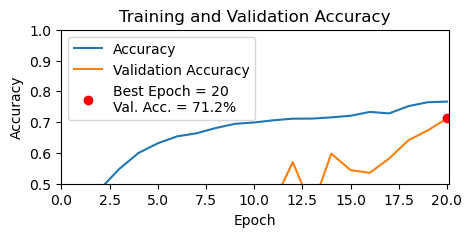

In [16]:
# Train new model and evaluate
now = train_new_model(model)

optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
checkpoint = ModelCheckpoint(f"model-comparison/{now}/model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(train_set,
                    epochs=20,
                    validation_data = val_set,
                    callbacks=[learning_rate_reduction, checkpoint],
                    )

loss_plot(model, history.history, now)

#os.system(finish_sound)


 PREDICTING LABELS OF TEST IMAGES
11/11 [==============================] - 2s 175ms/step

Accuracy of model prediction is: 72.35 %

F1-score of model prediction is: 72.14 %


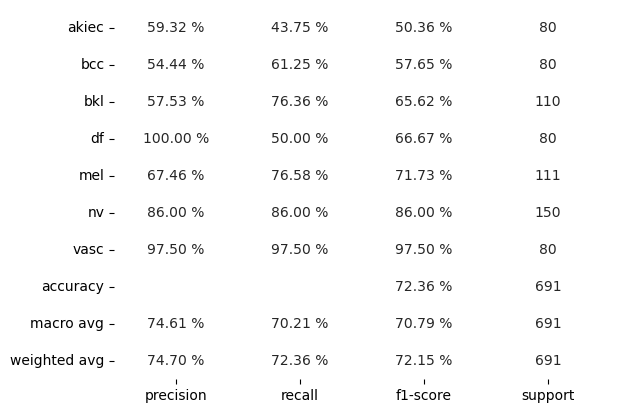

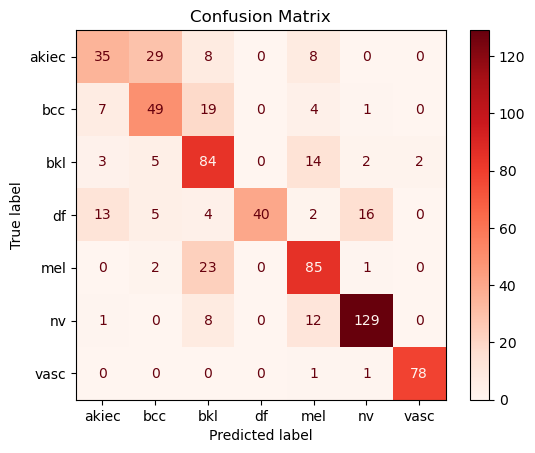


 PREDICTING LABELS OF TEST IMAGES
24/24 [==============================] - 5s 224ms/step

Accuracy of model prediction is: 52.48 %

F1-score of model prediction is: 55.69 %


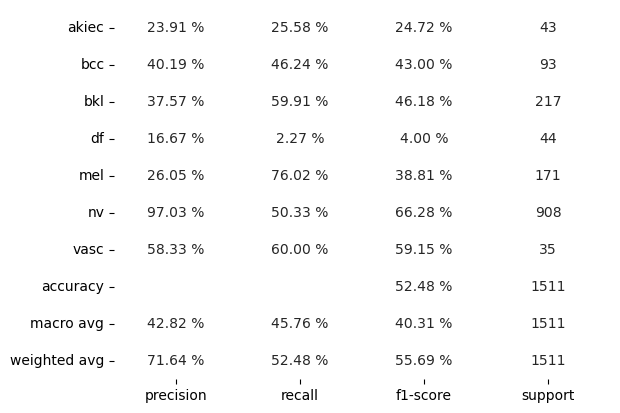

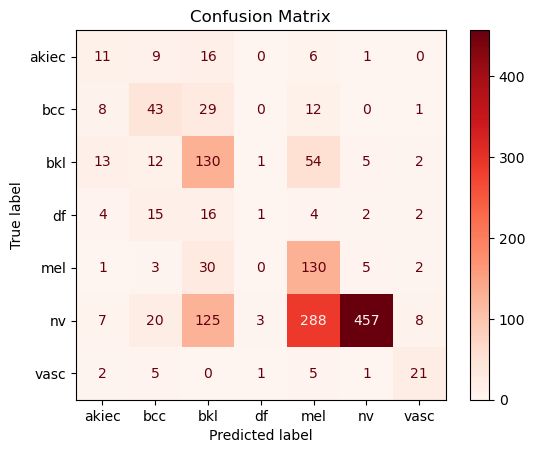

In [17]:
model = load_model(f"model-comparison/{now}/model.h5")

EvaluateModel(model, val_set, 'val', now)
EvaluateModel(model, test_set, 'test', now)

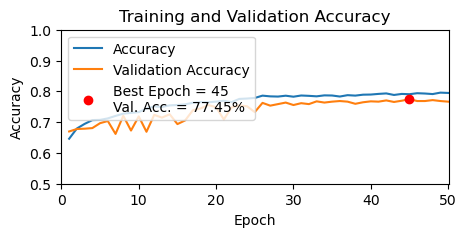


 PREDICTING LABELS OF TEST IMAGES
16/16 [==============================] - 4s 217ms/step

Accuracy of model prediction is: 76.64 %

F1-score of model prediction is: 74.55 %


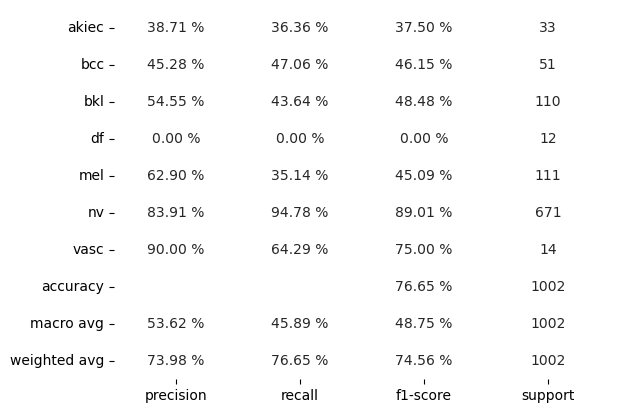

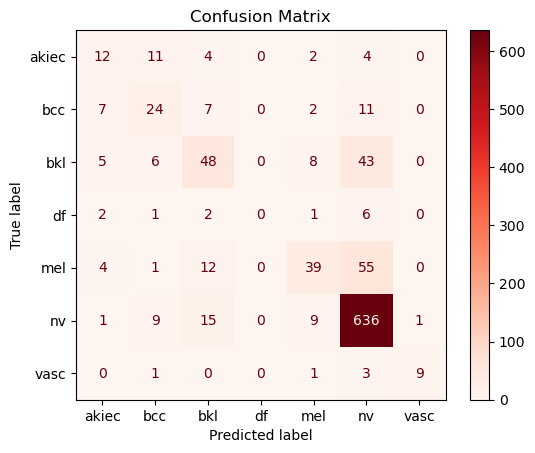


 PREDICTING LABELS OF TEST IMAGES
24/24 [==============================] - 5s 219ms/step

Accuracy of model prediction is: 70.21 %

F1-score of model prediction is: 67.42 %


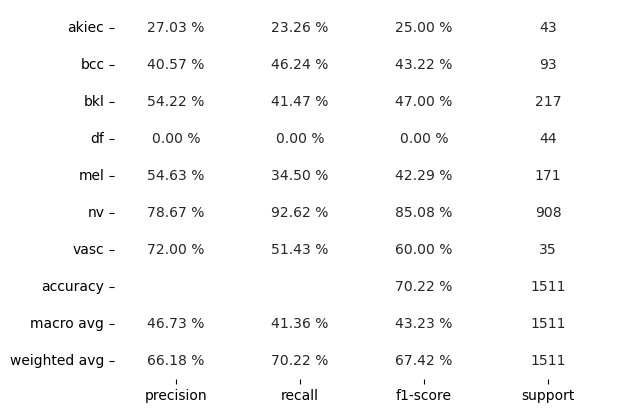

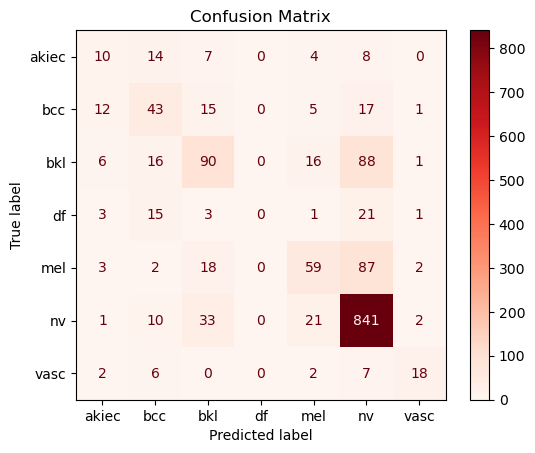

In [19]:
# Load Trained Model and Evaluate
# now = open('model-comparison/last.txt', 'r').read() 
now = '22-11-00-37' # best model so far
model = load_model(f"model-comparison/{now}/model.h5")
history = pd.read_csv(f'model-comparison/{now}/history.csv')
loss_plot(model, history, now, save=False)
EvaluateModel(model, val_set, 'val', now, save=False)
EvaluateModel(model, test_set, 'test', now, save=False)
